# JetSeT - fitting an observed SED from a BL Lac type object


#### This notebook shows how to <u>fit an SSC model</u> with JetSeT, using a minimizer (frequentist approach) or the MCMC method. We will further see how the fit can be performed after imposing physical constraints on the parameters.

In [1]:
#some initial imports
import matplotlib.pylab as plt
import numpy as np

import jetset
from jetset.jet_model import Jet
from jetset.data_loader import ObsData, Data
from jetset.plot_sedfit import PlotSED
from jetset.sed_shaper import SEDShape
from jetset.obs_constrain import ObsConstrain
from jetset.minimizer import ModelMinimizer
from jetset.model_manager import FitModel
from jetset.mcmc import McmcSampler

print (jetset.__version__)

1.3.0


### Loading data

We load a data file containinng a SED from a BL Lac type object. Let's use an SED from the TeV blazar Mrk421 collected in 2017. 
The SED covers a wide energy range, from radio to TeV energies. The data and analysis are described in the publication [MAGIC Collaboration et al., 2021, A&A, 655, A89](https://ui.adsabs.harvard.edu/abs/2021A%26A...655A..89M/abstract)

The data loading is performed with the `Data` class

In [2]:
filename = './data/fig15_mjd57785.dat'

d = np.genfromtxt(filename, usecols = (0, 1, 2, 3, 4, 5))
data = Data(n_rows=d.shape[0])
data.set_field('x',d[:,0]) #center frequency
data.set_field('dx',d[:,1]) # frequency bin width
data.set_field('y',d[:,3]) #nu_Fnu in erg/cm2/s
data.set_field('dy',value=d[:,4]) #nu_Fnu uncertainty in erg/cm2/s
data.set_field('UL',value=(d[:,4]==0)) #Upper limit (boolean flag)
data.set_meta_data('z',0.03)#set redshift of the source, here it is Mrk421 so z=0.03

print(data.table)

        x              dx           y       ... T_stop   UL  data_set
        Hz             Hz     erg / (s cm2) ...  MJD                 
------------------ ---------- ------------- ... ------ ----- --------
     15000000000.0        0.0    7.4218e-14 ...    0.0 False      0.0
 456000000000000.0        0.0    4.0266e-11 ...    0.0 False      0.0
1153000000000000.0        0.0    6.6528e-11 ...    0.0 False      0.0
1335000000000000.0        0.0    7.0621e-11 ...    0.0 False      0.0
1555000000000000.0        0.0    7.0752e-11 ...    0.0 False      0.0
        1.1765e+17 1.8516e+16     3.052e-10 ...    0.0 False      0.0
               ...        ...           ... ...    ...   ...      ...
        6.5385e+25 1.7025e+25    1.5086e-10 ...    0.0 False      0.0
        9.9399e+25 2.2805e+25    1.4457e-10 ...    0.0 False      0.0
        1.5623e+26 3.4916e+25     1.376e-10 ...    0.0 False      0.0
        2.4642e+26 5.4291e+25    1.3102e-10 ...    0.0 False      0.0
         3.894e+26 8

### Plotting the data
We plot the SED to inspect the data. This is done via `plot_sed()` from the `ObsData` object.

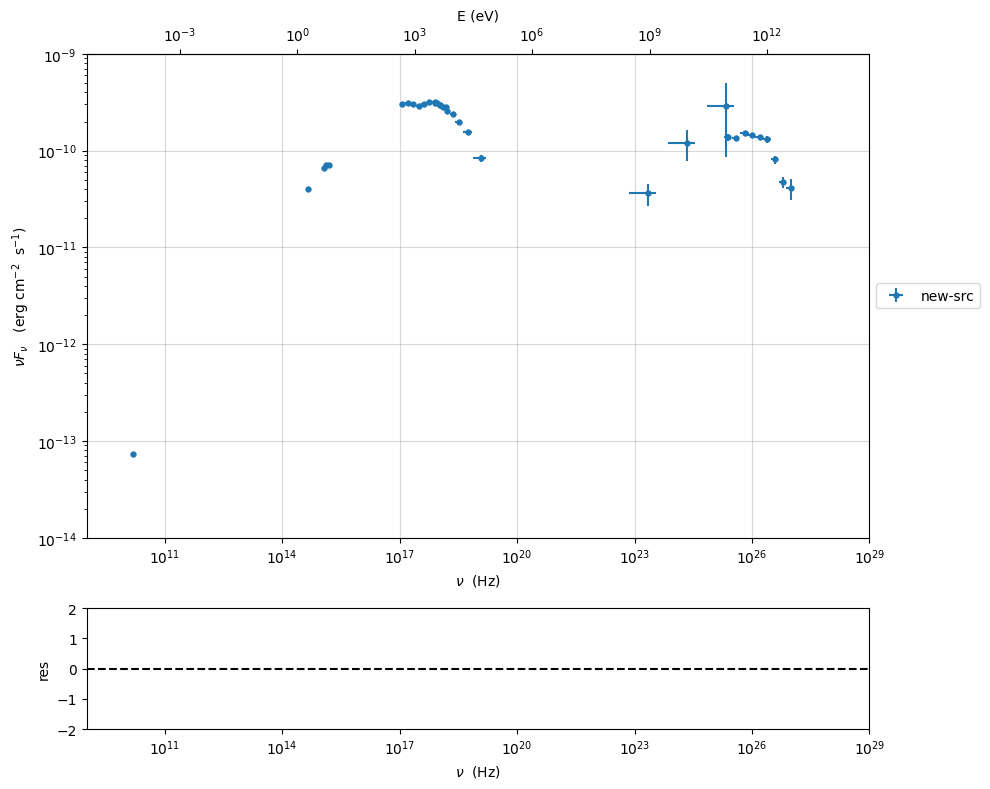

In [3]:
sed_data = ObsData(data_table=data)
sed_plot = sed_data.plot_sed()
sed_plot.setlim(y_min=1e-14,y_max=1e-9,x_min=1e9,x_max=1e29)

We then define a `Jet` instance, and associate an electron distribution shape (here a broken power-law, 'bkn')

In [4]:
#Define a jet instance
jet = Jet(name='SSC_Model', electron_distribution='bkn')
jet.show_pars()

===> setting C threads to 8


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
SSC_Model,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
SSC_Model,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
SSC_Model,B,magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,False
SSC_Model,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True
SSC_Model,beam_obj,beaming,,1.000000e+01,1.000000e-04,--,False,False
SSC_Model,z_cosm,redshift,,1.000000e-01,0.000000e+00,--,False,False
SSC_Model,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
SSC_Model,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
SSC_Model,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
SSC_Model,gamma_break,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False


In the next step, we pass the `jet` object to a `FitModel` instance, which will carry out the fit.

In [5]:
fit_model = FitModel(jet=jet, name='SSC-best-fit',template=None)


/home/axel/anaconda3/envs/jetset/lib/python3.10/site-packages/jetset/model_manager.py:158: UserWarning: no cosmology defined, using the one from jet FlatLambdaCDM(name="Planck13", H0=67.77 km / (Mpc s), Om0=0.30712, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.048252)
  warnings.warn(m)


Before proceeding with the fit, we first freeze a couple of parameters. Indeed, several parameters such as $\gamma_{\rm max}$ or $\gamma_{\rm min}$ are usually poorly constrained by the data and freezing them improves the convergence. Finally, we freeze the redshift of the source $z$ to 0.03 (this is not a free parameter of the model).

In [6]:
fit_model.freeze(jet,'z_cosm')
fit_model.SSC_Model.parameters.z_cosm.val=0.03 

fit_model.freeze(jet,'gmax')
fit_model.SSC_Model.parameters.gmax.val=1e6

fit_model.freeze(jet,'gmin')
fit_model.SSC_Model.parameters.gmin.val=3e3

Furthermore, we give some starting value to the free parameters (selecting values close to the ones typically obtained in leptonic models in blazars) to facilitate the convergence.

In [7]:
fit_model.SSC_Model.parameters.R.val=1e16
fit_model.SSC_Model.parameters.R.fit_range=[1e14, 1e18]

fit_model.SSC_Model.parameters.B.val=1e-1
fit_model.SSC_Model.parameters.B.fit_range=[1e-3, 1e1]

fit_model.SSC_Model.parameters.gamma_break.val=1e5
fit_model.SSC_Model.parameters.gamma_break.fit_range=[1e3, 1e6]

fit_model.SSC_Model.parameters.p.val=2
fit_model.SSC_Model.parameters.p.fit_range=[1, 4]

fit_model.SSC_Model.parameters.p_1.val=3
fit_model.SSC_Model.parameters.p_1.fit_range=[1, 4]


We are now ready to run the fit. The last step is to define the minimizer: 'lsb' (wrapping the scipy least_squares package), 'minuit' (wrapping the iminuit package) or sherpa. For sherpa the plugin needs to be installed beforehand. Typically, 'lsb' is the fastest. 'minuit' can have trouble to converge when it is far from the optimal. 

A good compromise is to first run the fit with 'lsb', and repeat the fit with 'minuit'

In [8]:
model_minimizer = ModelMinimizer('lsb')
#Running the fit with fit() function. The third argument give the fitting range,  here from 1e14Hz to 1e28 Hz
best_fit_lsb = model_minimizer.fit(fit_model,sed_data,1e14,1e28, fitname='SSC-best-fit',repeat=3, silent=True)

#and now with the minuit minimize
model_minuit_minimizer = ModelMinimizer('minuit')
best_fit_minuit = model_minuit_minimizer.fit(fit_model,sed_data,1e14,1e28,fitname='SSC-best-fit',repeat=3, silent=True)


====> simplex
====> migrad
====> simplex
====> migrad
====> simplex
====> migrad


In [9]:
best_fit_minuit.success

True

The fit converged, and we can now plot the best fit model using the `plot_model()` method of the `fit_model` object

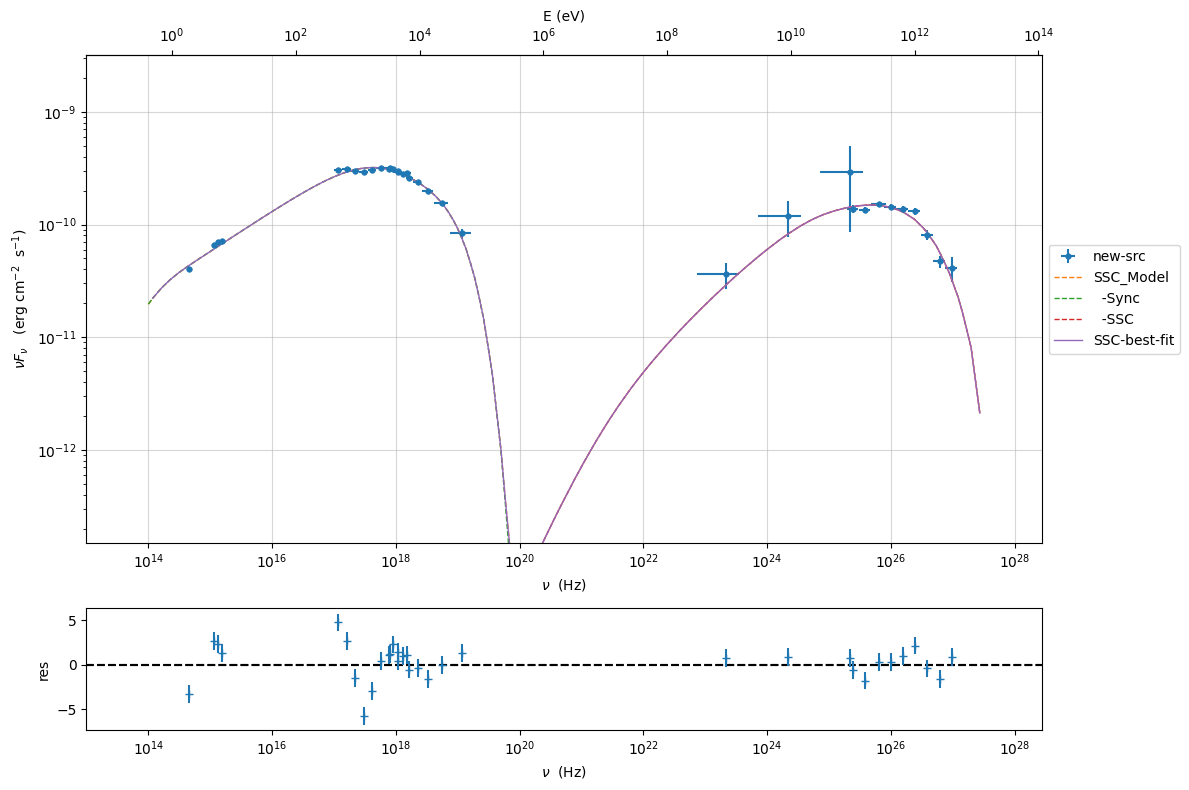

In [10]:
plot = fit_model.plot_model(sed_data=sed_data)

In [11]:
best_fit_minuit.bestfit_table #get the parameter table

model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
str9,str16,float64,float64,float64,float64,float64,float64,float64,bool
SSC_Model,R,6.270001e+15,6.270001e+15,9.397882e+13,--,6.271139e+15,1.000000e+14,1.000000e+18,False
SSC_Model,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
SSC_Model,B,6.309921e-02,6.309921e-02,8.758355e-05,--,6.309958e-02,1.000000e-03,1.000000e+01,False
SSC_Model,NH_cold_to_rel_e,1.000000e+00,--,--,--,1.000000e+00,0.000000e+00,--,True
SSC_Model,beam_obj,3.396253e+01,3.396253e+01,3.492490e-02,--,3.396275e+01,1.000000e-04,--,False
SSC_Model,z_cosm,3.000000e-02,--,--,--,3.000000e-02,0.000000e+00,--,True
SSC_Model,gmin,3.000000e+03,--,--,--,3.000000e+03,1.000000e+00,1.000000e+09,True
SSC_Model,gmax,1.000000e+06,--,--,--,1.000000e+06,1.000000e+00,1.000000e+15,True
SSC_Model,N,1.255270e+00,1.255270e+00,5.434289e-02,--,1.254282e+00,0.000000e+00,--,False


In [12]:
B_best_fit = fit_model.SSC_Model.parameters.B.best_fit_val # get the parameter value
B_uncertainty = fit_model.SSC_Model.parameters.B.best_fit_err # get the parameter error
print (f'B-field = {B_best_fit:.2g} +/- {B_uncertainty:.2g}')

B-field = 0.063 +/- 8.8e-05


### MCMC fitting procedure

The fit can also be performed using a MCMC fitting algorithm (bayesian approach) from the `McmcSampler` class

In [15]:
mcmc = McmcSampler(model_minimizer)

We first set the parameters to be sampled. By default, it will use the same as the `model_minimizer` (frequentist) fit

In [16]:
mcmc.set_labels()

But if one can also define manually the parameters to be sampled, if they need to be different than `model_minimizer`

`labels=['R', 'N','B','p','p_1']` <br>
`model_name='SSC_model' `<br>
`use_labels_dict={model_name:labels}`<br>
`mcmc.set_labels(use_labels_dict=use_labels_dict)`<br>


We now set the bounds for each parameter 

In [18]:
mcmc.set_bounds(bound=5.0, bound_rel=True)

par: R  best fit value:  6270001033259106.0  mcmc bounds: [100000000000000.0, 3.762000619955463e+16]
par: B  best fit value:  0.0630992069686158  mcmc bounds: [0.001, 0.37859524181169485]
par: beam_obj  best fit value:  33.96252919186174  mcmc bounds: [0.0001, 203.77517515117043]
par: N  best fit value:  1.2552702438990258  mcmc bounds: [0, 7.5316214633941545]
par: gamma_break  best fit value:  198965.04232183174  mcmc bounds: [1000.0, 1000000.0]
par: p  best fit value:  2.278757574599803  mcmc bounds: [1, 4]
par: p_1  best fit value:  3.3700792193237787  mcmc bounds: [1, 4]


And run the sampler

In [19]:
mcmc.run_sampler(nwalkers=20, burnin=10, steps=100, progress='notebook')

===> setting C threads to 8
mcmc run starting



  0%|          | 0/100 [00:00<?, ?it/s]

mcmc run done, with 1 threads took 43.43 seconds


Let's plot the corner plot, with the desired quantiles plotted with vertical dashed lines.

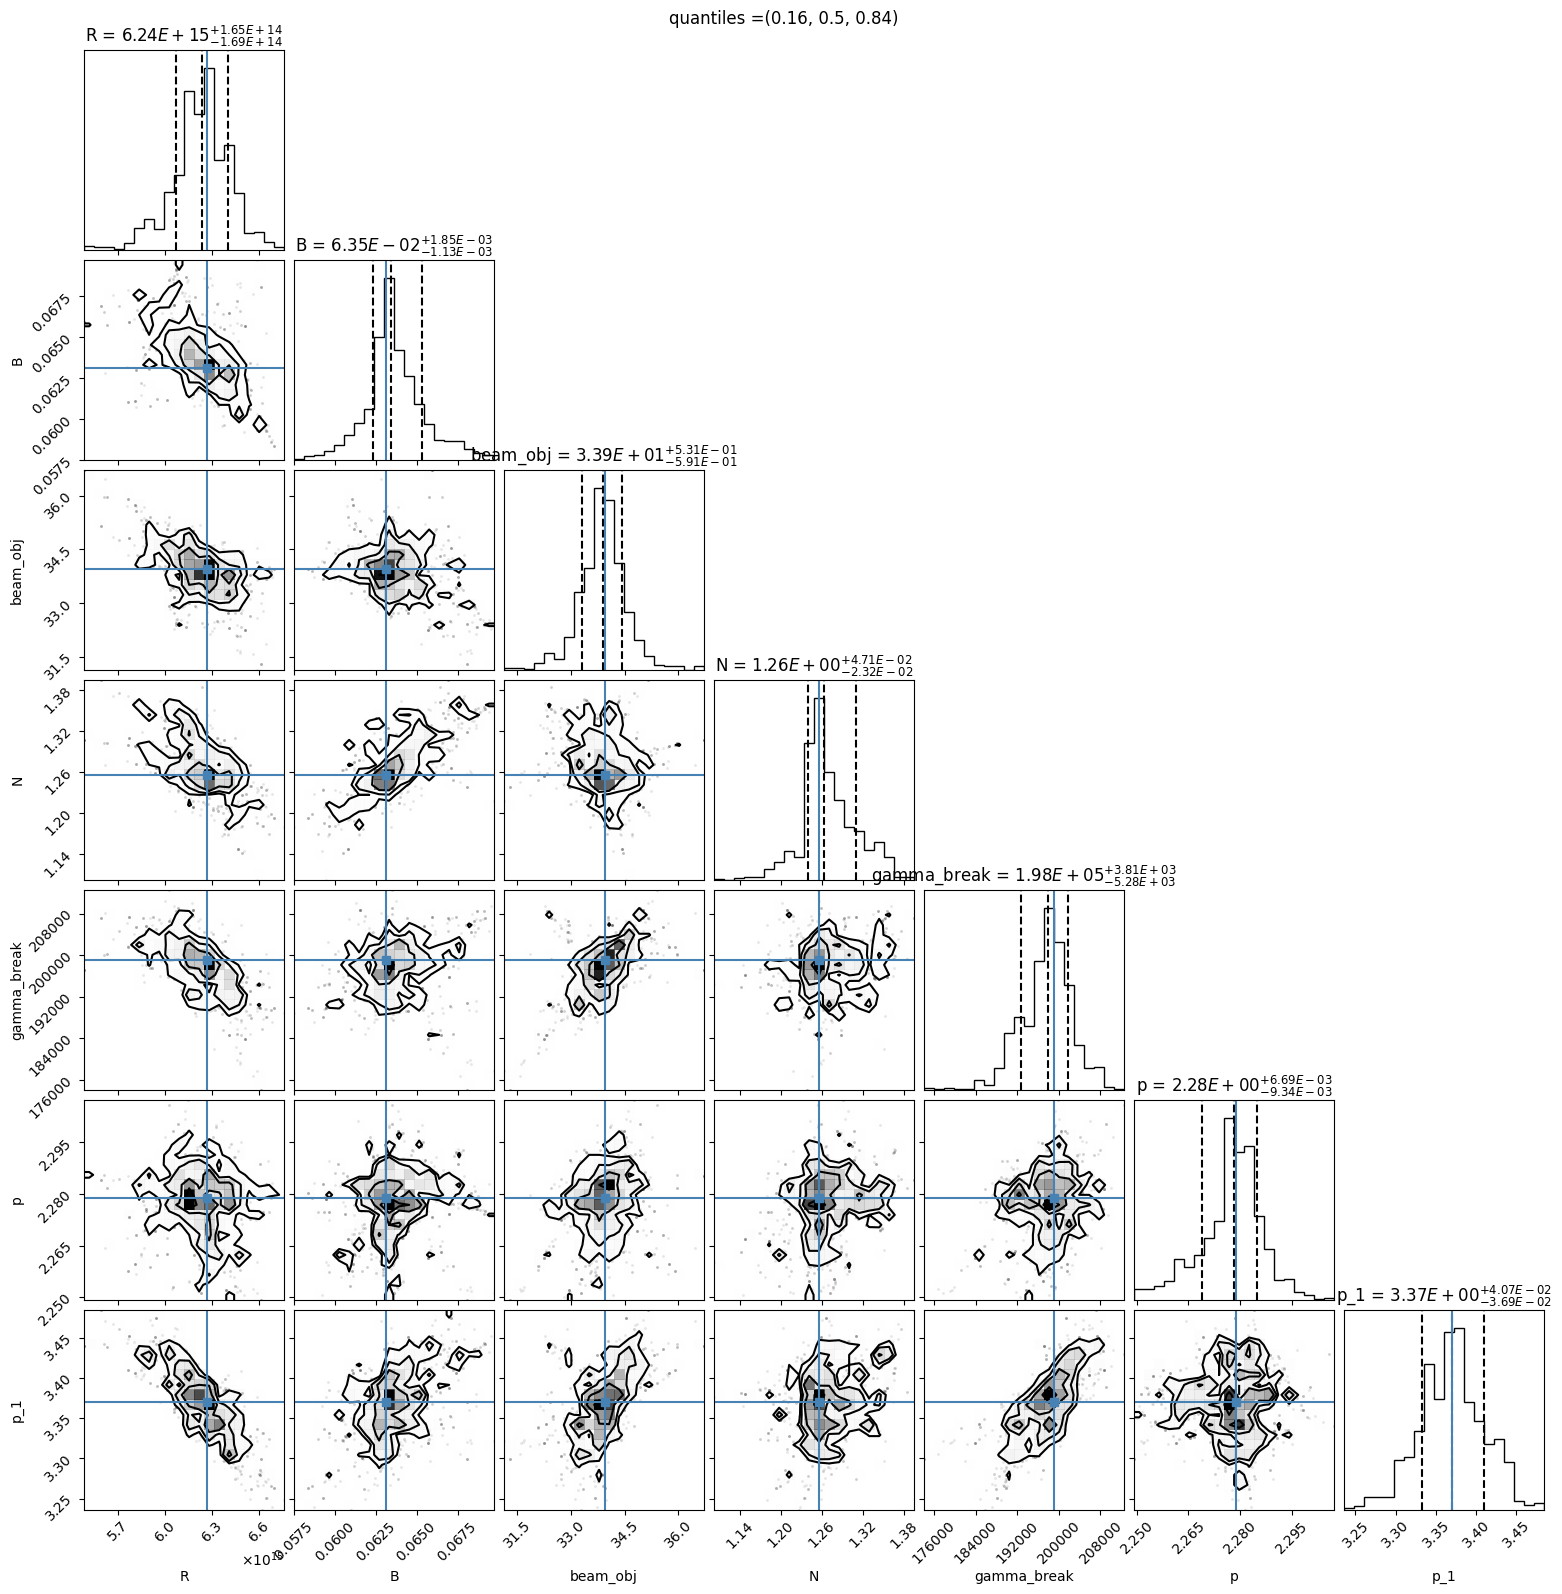

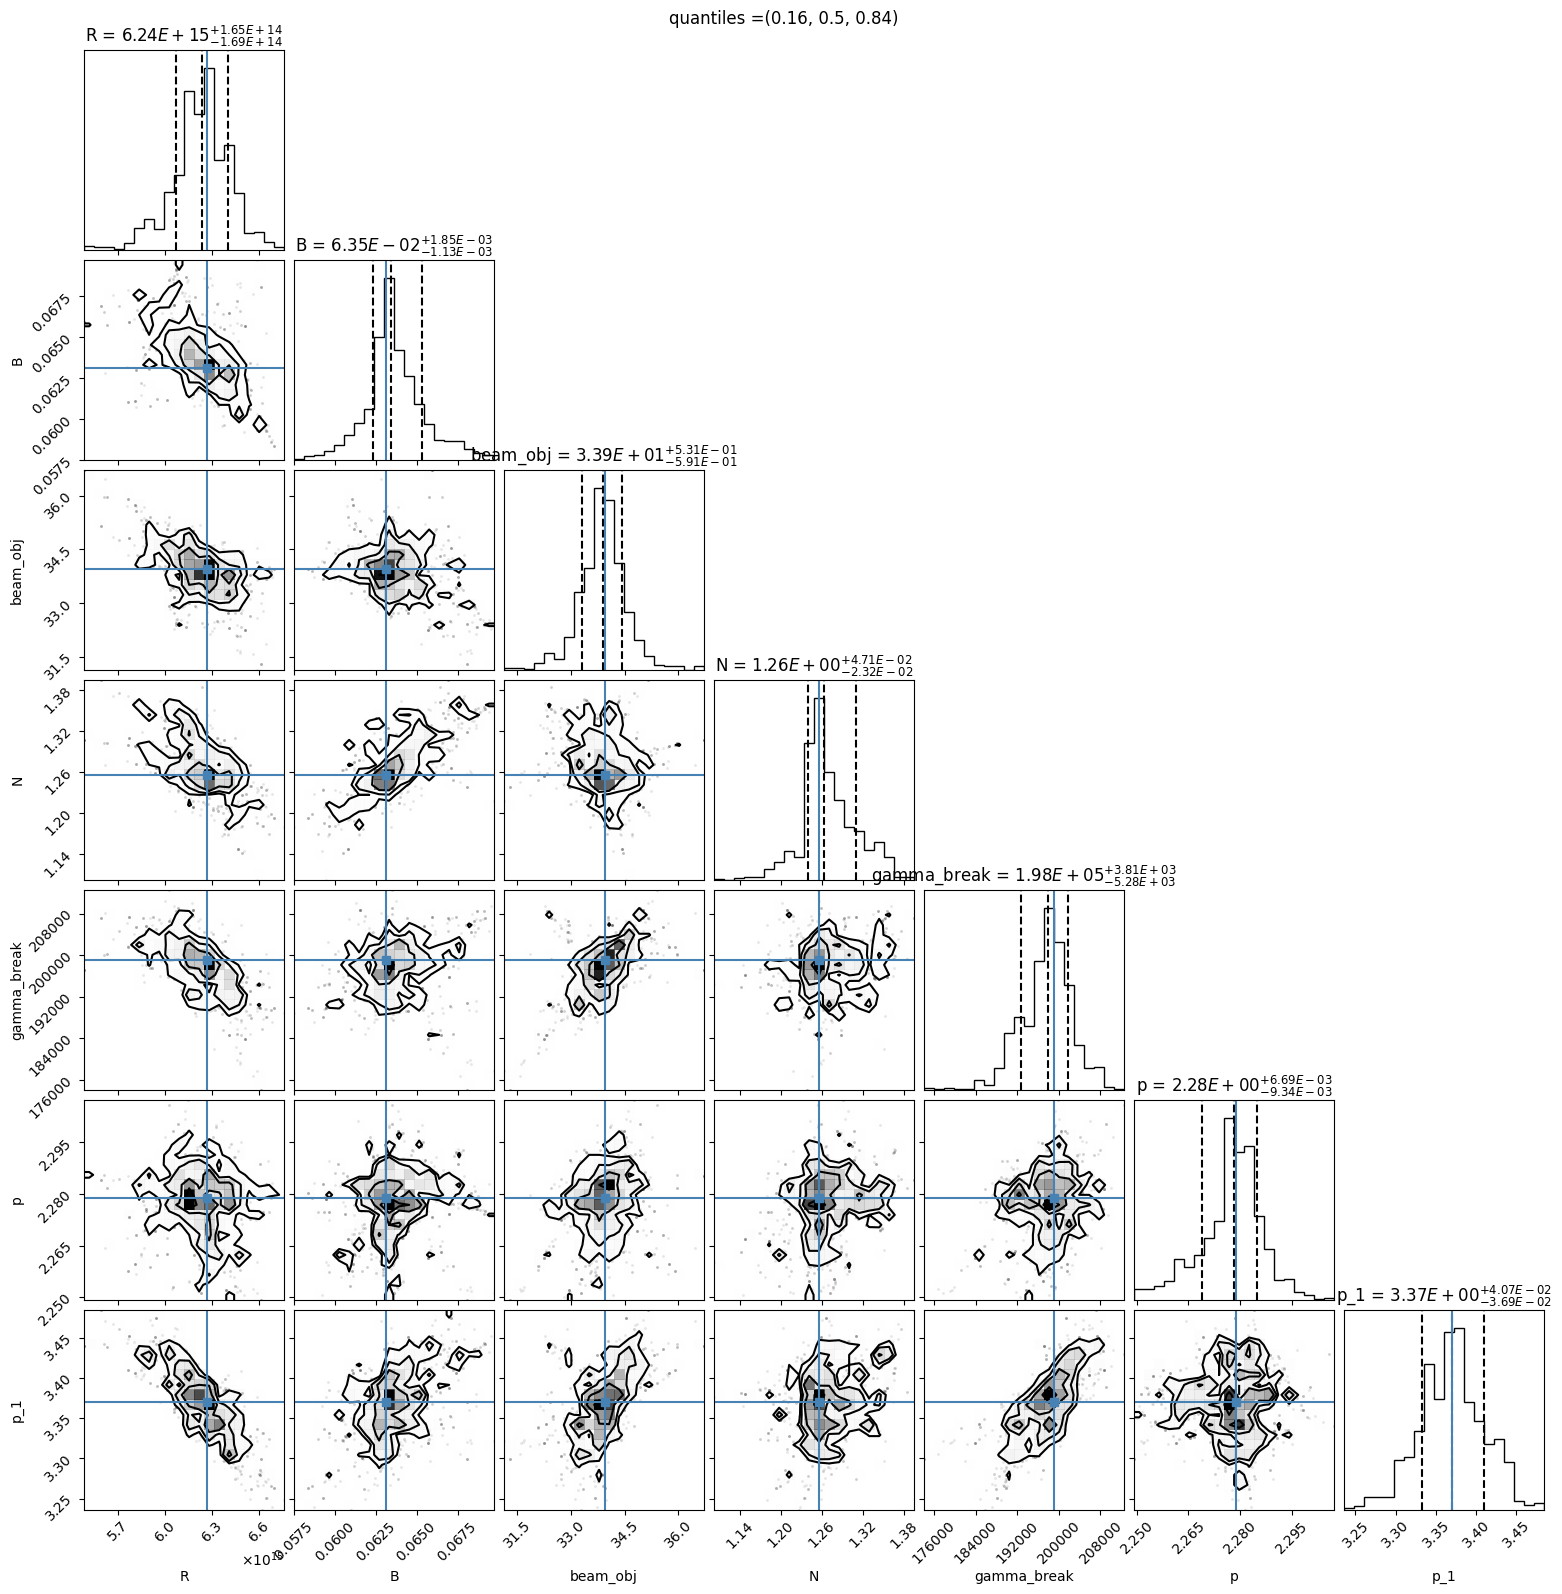

In [20]:
mcmc.corner_plot(quantiles=(0.16, 0.5, 0.84),title_kwargs=dict(fontsize=12),title_fmt=".2E",use_math_text=True)

And now the model "band", also with the desired quantiles plotted

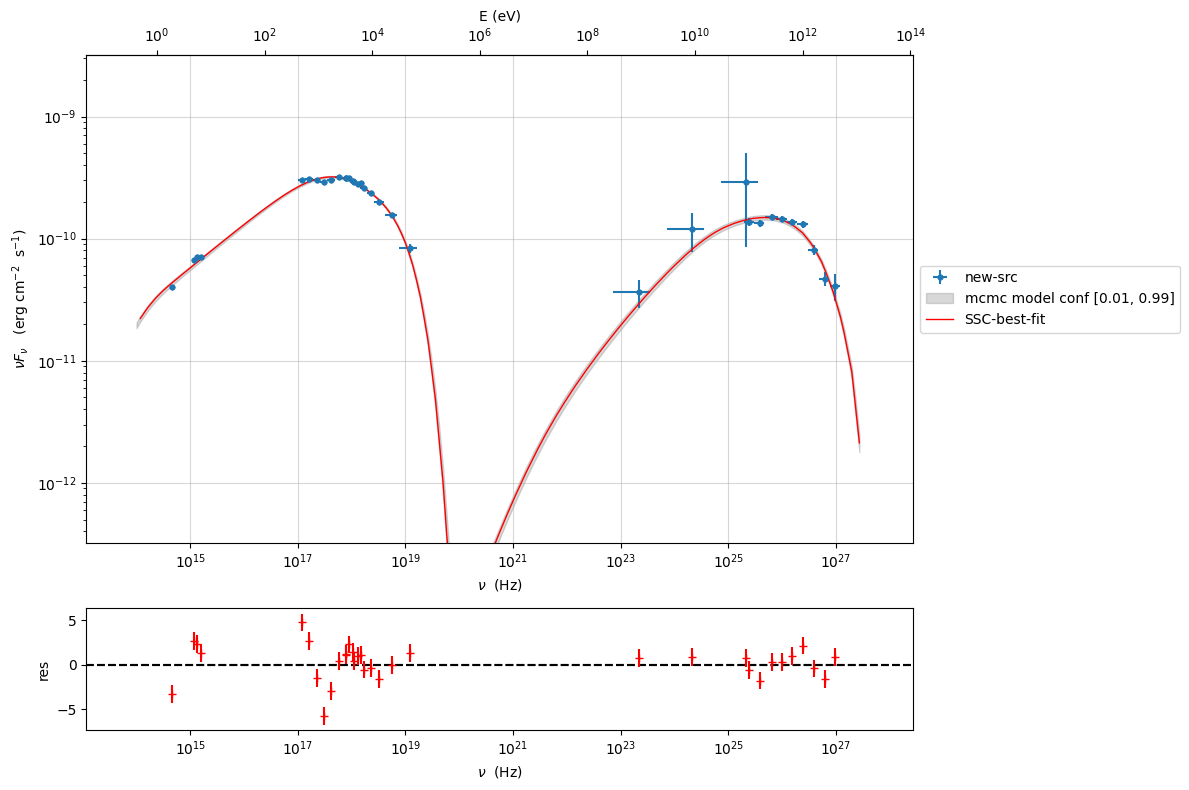

In [21]:
mcmc.plot_model(sed_data=sed_data, quantiles=[0.01,0.99])

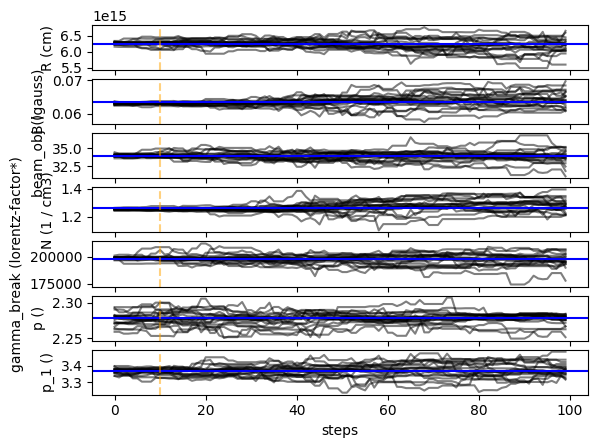

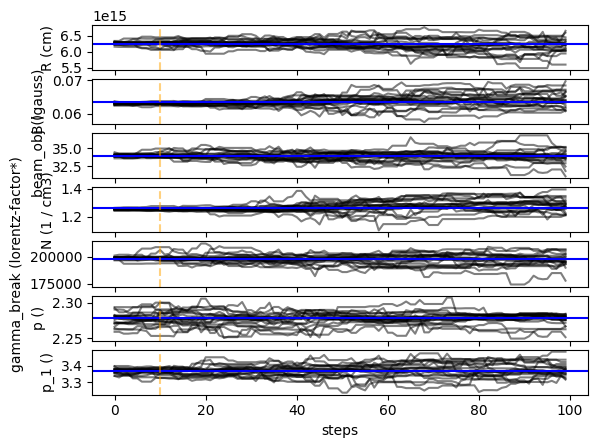

In [22]:
mcmc.plot_chain(log_plot=False)

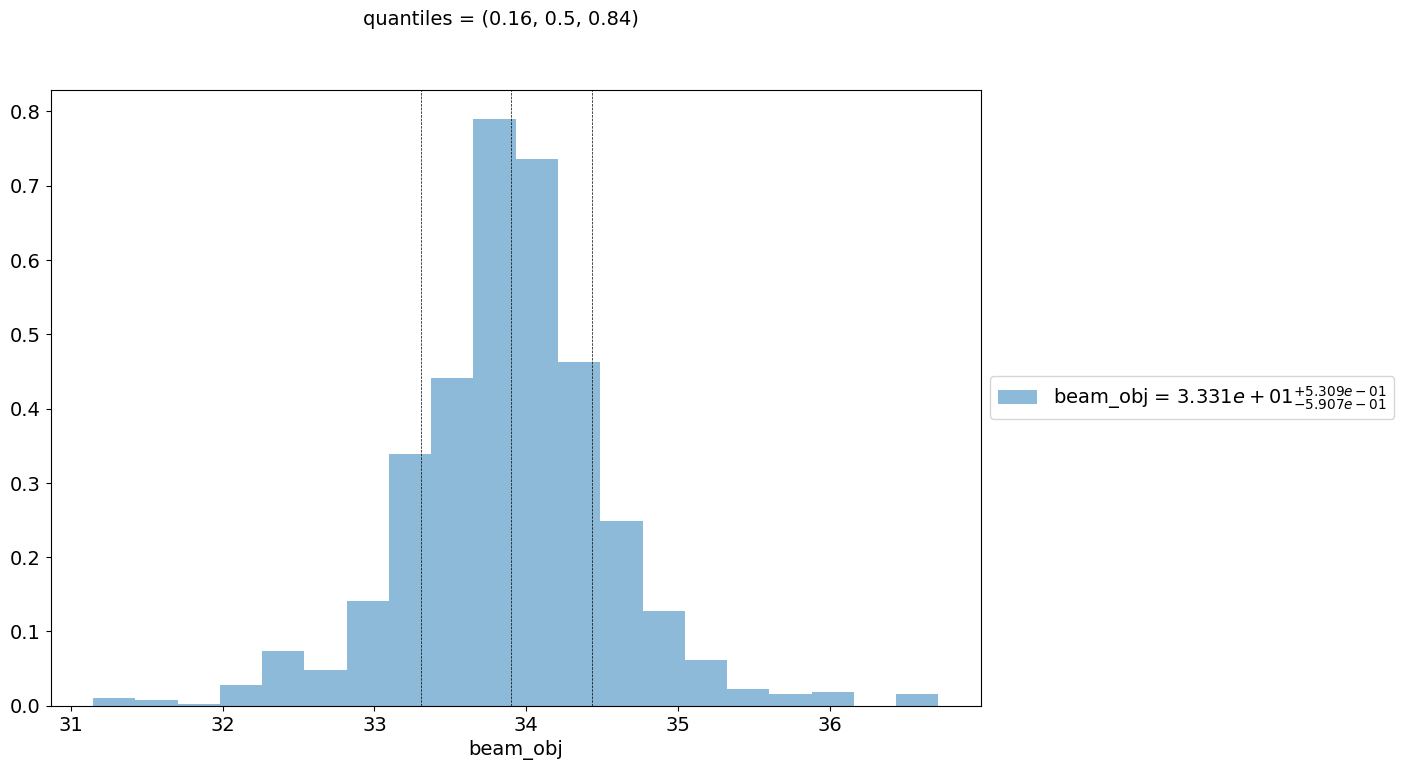

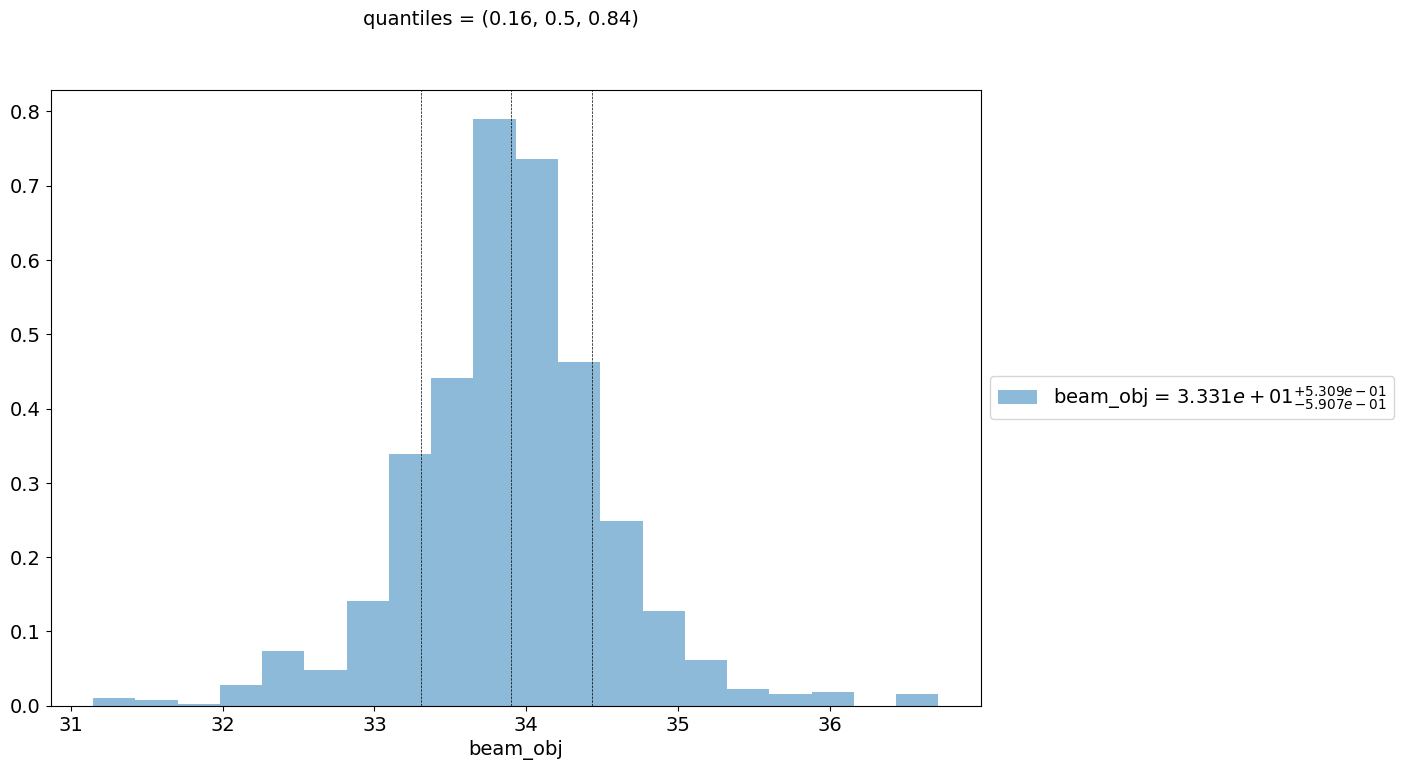

In [23]:
mcmc.plot_par('beam_obj')

### Adding physical constraints to the parameters

While getting a fit of the data is great, the fitting routine does not care about the physics :)
It is important to ask our selves if we could get a fit with comparable quality but using a particle distribution whose shape matches an equilibrium state (after considering particle escape and cooling).

A cooling break of $\Delta p = p_1 - p = 1$ is expected due to particle cooling (due to synchrotron & inverse-compton radiation). Assuming that particle escape the emitting region on a timescale $t_{esc} \sim R/c$, and that most of the energy is radiated via synchrotron emission, the cooling break must take place at a Lorentz factor $\gamma_{\rm break, syn}$:
<div align="center">
$$
\gamma_{\rm break, syn} = \frac{3 m_e c^2}{4\sigma_T U_B R}
$$
</div>

where $U_B = B^2/8\pi$ is the magnetic field energy density.

Adding such a constrain between $\gamma_{\rm break}$, $R$, $B$, $p$ and $p_1$ is possible in JetSeT via the `make_dependent_par()` method in the `fit_model` object.

In [24]:
import astropy.units as u
from astropy.constants import c, m_e, sigma_T


Let's define the function relating the parameters $\gamma_{\rm break}$, $R$, $B$, $p$ and $p_1$

In [25]:
def th_cooling_lorentz_break(B, R):
    R = R*u.cm
    Ub = B**2/(8*np.pi)* u.erg/u.cm**3
    
    gamma_break = (3*m_e*c**2).to("erg")/(4*sigma_T.to(u.cm**2)*Ub*R)

    return gamma_break.value

def th_cooling_slope_break(p):
    
    return p+1

In [26]:
fit_model.SSC_Model.make_dependent_par(par='gamma_break', depends_on=['B', 'R'], par_expr=th_cooling_lorentz_break)
fit_model.SSC_Model.make_dependent_par(par='p_1', depends_on=['p'], par_expr=th_cooling_slope_break)


adding par: B to  gamma_break
adding par: R to  gamma_break
==> par gamma_break is depending on ['B', 'R'] according to expr:   gamma_break =
def th_cooling_lorentz_break(B, R):
    R = R*u.cm
    Ub = B**2/(8*np.pi)* u.erg/u.cm**3
    
    gamma_break = (3*m_e*c**2).to("erg")/(4*sigma_T.to(u.cm**2)*Ub*R)

    return gamma_break.value

adding par: p to  p_1
==> par p_1 is depending on ['p'] according to expr:   p_1 =
def th_cooling_slope_break(p):
    
    return p+1



====> simplex
====> migrad
====> simplex
====> migrad
====> simplex
====> migrad


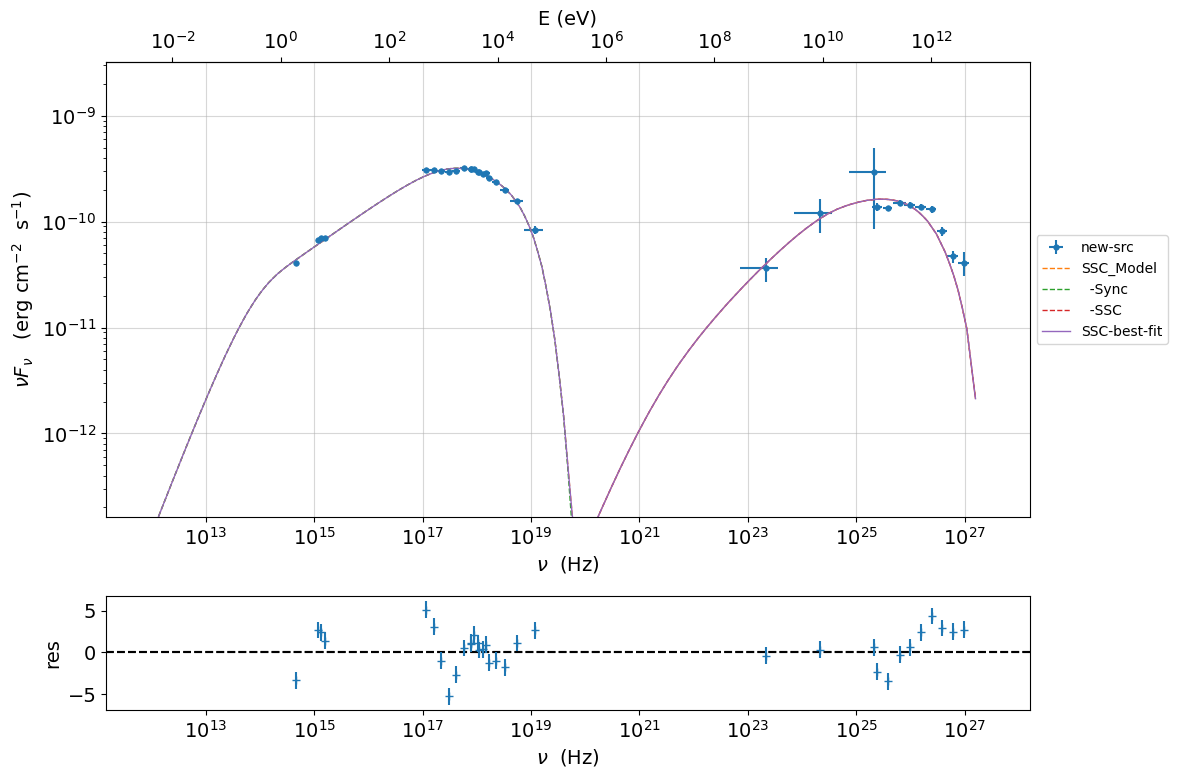

In [27]:
best_fit_constrained = model_minuit_minimizer.fit(fit_model,sed_data,1.2e12,1e28,fitname='SSC-best-fit',repeat=3,silent=True)
plot = fit_model.plot_model(sed_data=sed_data)


In [28]:
best_fit_constrained.bestfit_table

model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
str9,str17,float64,float64,float64,float64,float64,float64,float64,bool
SSC_Model,R(M),1.150327e+16,1.150327e+16,3.462854e+14,--,6.270001e+15,1.000000e+14,1.000000e+18,False
SSC_Model,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
SSC_Model,B(M),9.743169e-02,9.743169e-02,1.846945e-03,--,6.309921e-02,1.000000e-03,1.000000e+01,False
SSC_Model,NH_cold_to_rel_e,1.000000e+00,--,--,--,1.000000e+00,0.000000e+00,--,True
SSC_Model,beam_obj,1.843346e+01,1.843346e+01,2.530878e-01,--,3.396253e+01,1.000000e-04,--,False
SSC_Model,z_cosm,3.000000e-02,--,--,--,3.000000e-02,0.000000e+00,--,True
SSC_Model,gmin,3.000000e+03,--,--,--,3.000000e+03,1.000000e+00,1.000000e+09,True
SSC_Model,gmax,1.000000e+06,--,--,--,1.000000e+06,1.000000e+00,1.000000e+15,True
SSC_Model,N,9.248492e-01,9.248492e-01,4.935855e-02,--,1.255270e+00,0.000000e+00,--,False


In [29]:
best_fit_minuit.success

True

In [30]:
print (f'Chi2 with the Minuit fit {best_fit_minuit.chisq}')
print (f'Ndof with the Minuit fit {best_fit_minuit.dof}')

Chi2 with the Minuit fit 130.10602138050876
Ndof with the Minuit fit 27


In [31]:
print (f'Chi2 with the "Physically constrained" fit {best_fit_constrained.chisq}')
print (f'Ndof with the "Physically constrained" fit {best_fit_constrained.dof}')

Chi2 with the "Physically constrained" fit 186.6067699074638
Ndof with the "Physically constrained" fit 29


*Note: since we added two equations to make parameters interdependent, the difference in the Ndof is 2.*

The fit quality is lower when physical constraints are imposed, as expected. However, the obtained parameters are self-consistent according to first principles, and for this reason deserve some consideration. 

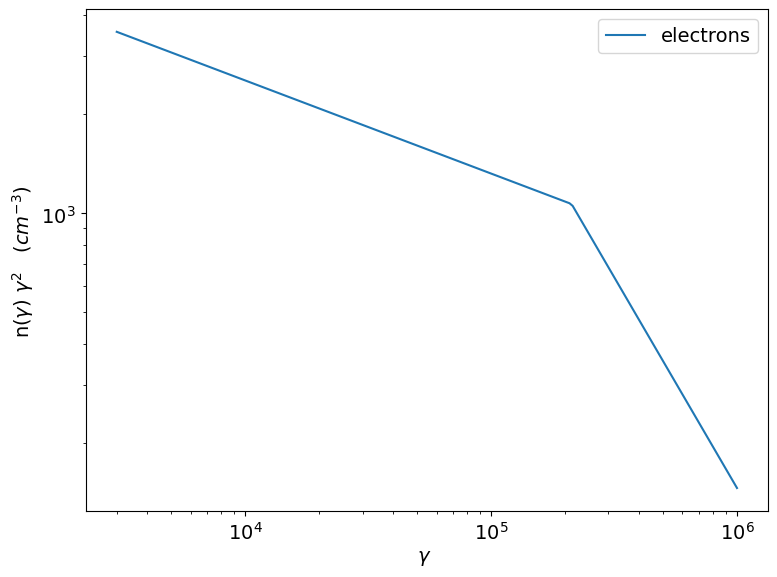

In [33]:
jet.electron_distribution.plot2p()